In [118]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [119]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [120]:
#load data
mnist_train = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# make validation set

train_length = len(mnist_train)
train_size = int(0.85 * train_length)
val_size = train_length - train_size

mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [train_size, val_size])

# store train and val loss
train_loss_list = []
val_loss_list = []
epoch_list = []
train_acc_list = []
val_acc_list = []

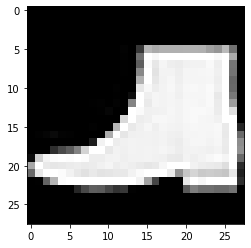

In [121]:
# visualise sample of data to know what we are dealing with
plt.figure(1)
img, label = mnist_train[5]
plt.imshow(img.squeeze(), cmap='gray')

In [122]:
img.size()

torch.Size([1, 28, 28])

In [123]:
# make network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 16 from batchnorm, 14 from pooling
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128,10)
        # self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 64 * 7 * 7)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        # out = self.act2(out)
        return out


In [124]:
# train and test loop
def train_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):

    best_val_acc = 0.0
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        train_total = 0.0
        train_correct = 0.0
        val_total = 0.0
        val_correct = 0.0
        for imgs, labels in train_loader:
            # move tensors to gpu
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            train_total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            train_correct += int((predicted == labels).sum())



        epoch_list.append(epoch)
        train_loss_list.append(loss_train / len(train_loader))

        # get loss of validation data
        with torch.no_grad():
            loss_val = 0.0


            for imgs, labels in val_loader:
                # move tensors to gpu if available
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)

                loss_v = loss_fn(outputs, labels)

                loss_val += loss_v.item()

                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
                val_total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
                val_correct += int((predicted == labels).sum())



        val_loss_list.append(loss_val / len(val_loader))

        val_acc = val_correct/val_total

        train_acc_list.append(train_correct/train_total)
        val_acc_list.append(val_acc)

        if val_acc > best_val_acc:
            print('Found better model')
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'mnist_digits_nn.pt')

        # set when to print info about training progress
        if epoch == 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {:.4f}, Validation loss {:.4f}, Train Acc {:.4f}, Val Acc {:.4f}'.format(epoch, loss_train / len(train_loader), loss_val / len(val_loader), train_correct/train_total, val_acc),
                  )
            print('Best Val Acc {:.4f}'.format(best_val_acc))
        

    model = Net()
    model.load_state_dict(torch.load('mnist_digits_nn.pt'))


def test_loop(model, test_loader):
    correct = 0.0
    total = 0.0

    with torch.no_grad():
        for imgs, labels in test_loader:
            # move to gpu
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())


    print("Accuracy test: {:.4f} %".format(correct / total))

In [ ]:
# set model and params
n_epochs = 25
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test,  batch_size=64, shuffle=False)
# epoch_num_of_no_improve = 5


train_loop(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader)


print('Accuracy score')
test_loop(model, val_loader)
print('Test score')
test_loop(model, test_loader)



Found better model
Epoch 1, Training loss 0.5013, Validation loss 0.3639, Train Acc 0.8385, Val Acc 0.8721
Best Val Acc 0.8721
Found better model
Epoch 2, Training loss 0.2890, Validation loss 0.2889, Train Acc 0.8943, Val Acc 0.8982
Best Val Acc 0.8982
Found better model
Epoch 3, Training loss 0.2490, Validation loss 0.2717, Train Acc 0.9100, Val Acc 0.9038
Best Val Acc 0.9038
Found better model
Epoch 4, Training loss 0.2248, Validation loss 0.2752, Train Acc 0.9171, Val Acc 0.9042
Best Val Acc 0.9042
Epoch 5, Training loss 0.2056, Validation loss 0.3032, Train Acc 0.9262, Val Acc 0.9007
Best Val Acc 0.9042
Epoch 6, Training loss 0.1931, Validation loss 0.3203, Train Acc 0.9294, Val Acc 0.9000
Best Val Acc 0.9042
Epoch 7, Training loss 0.1842, Validation loss 0.3527, Train Acc 0.9322, Val Acc 0.8890
Best Val Acc 0.9042
Epoch 8, Training loss 0.1753, Validation loss 0.3215, Train Acc 0.9362, Val Acc 0.9017
Best Val Acc 0.9042
Epoch 9, Training loss 0.1626, Validation loss 0.3186, Train

In [ ]:
plt.figure(2)
plt.plot(epoch_list, train_loss_list, color='blue', label='train_loss')
plt.plot(epoch_list, val_loss_list, color='green', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [ ]:
plt.figure(3)
plt.plot(epoch_list, train_acc_list, color='blue', label='train acc')
plt.plot(epoch_list, val_acc_list, color='green', label='validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_fit = np.array([])
y_test = np.array([])

for imgs, labels in test_loader:
    model = model.to('cpu')

    outputs = model(imgs)

    _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
    predicted = predicted.detach().numpy()
    labels = labels.detach().numpy()
    y_fit = np.concatenate((y_fit, predicted), axis=None)
    y_test = np.concatenate((y_test, labels), axis=None)
    # y_fit.append(predicted)
    # y_test.append(labels)

labels_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

plt.figure(6, dpi=180)
conf_matrix = confusion_matrix(y_test, y_fit)
conf_matrix = pd.DataFrame(conf_matrix)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels_names, yticklabels=labels_names, cmap='magma')
plt.xlabel('true label')
plt.ylabel('predicted label')